# Research question and overview of the data 

At this moment, over 20 million people are attending US colleges. These students come from a wide variety of backgrounds, but they all expect college to provide them with opportunity and help them acheive financial stability. We use college level data to analyze how well Pell Grants are being distributed and how well they help students from poorer backgrounds acheive financial success.

This dataset combines data produced by Opportunity Insight and the US Department of Education. Opportunity Insight keeps track of various data about US colleges, such as the number of students enrolled at each college, acceptance rates, and cost of tuition. The Opportunity Insight data also contains information about racial demographics, university type (public, private, for profit) and student's majors. What makes Opportunity Insight's dataset unique is the variables it contains about student and parent income. This dataset is one of the most prominent ways to gain insight into upwards mobility and opportunity at US colleges. It can help data scientists identify which colleges are serving the rich over the poor and majorities over minorities. Using tax records, the data scientists at Opportunity Insight were able to track the income of students and their parents before and after the student attended college. This allows for variables showing what percent of students at any given university come from wealthy backgrounds and what percent come from poor backgrounds. Several variales relate to how many students from poor families go on to be wealthy. As this data is all on a university level, it can be combined with information about the university to gain more general insights about upwards mobility and the opportunity college provides.

Financial aid information was then added to this dataset. Every year, the US Department of Education gives Pell Grants, the foundation of a student's financial aid package, to students with financial need. The Department of Education keeps track of how many grants are given to each univeristy and the total dollar amount awarded to each university. Students with more need receive a larger grant, with the money automatically being used to subsidize tuition. Any leftover funds can be used however the student chooses, and at no point in time do these funds need to be repaid. 

While these datasets are a rich source of information, they do have limitations. Notably, Opportunity Insight data spans several years, and some variables are more recent than others, with most from the early 2000s and several from 2013 or 2014. In addition, the Opportunity Insight datasets have missing variables. This is adressed below. Income information in particular is missing for around ten percent of schools. Income information is originally extracted from tax records, and this process is imperfect, causing missing and occasionally incorrect variables. On top of this, tax records are noisy, imprecise records of income, meaning any given income extracted has random error to it. It should also be noted that these variables are the average of a sample instead of a universal average. A small percentage of the tax records from students at each university were obtained.

It is also notable that both Opportunity Insight and Pell Grant data provide information at a college level instead of an individual level. This makes it harder to identify a direct relationship between a student's background, their college expereince, and their financial outcomes. However, the dataset is still robust enough to provide insight into the opportunities colleges provide, as well as the effectiveness of Pell Grants. This approach also protect students' privacy and mitigates noise in the text extraction process.

We expect this analysis to identify the traits of colleges with high upwards mobility, as measured by income. We expect that Pell Grants will contribute to upwards mobility.

# Data Cleaning/ Feature Engineering

Data from Opportunity Insight have a common id (super_opeid), so joining multiple tables is straightforward. We joined two tables, one with general college information and one with student income information. This join did result in some missing values, which are shown in this graph

TODO: Include "assessing_opportunity_insight.png"

In the graph above, we show what percent of observations are missing in the join between the two Opportunity Insight datasets. One dataset has features about general college statistics, and the other has features about student income and upwards mobility. The first dataset has at most two percent of any given variable missing after the join, while ten percent of the income data is missing. This is likely do to the difficulty of extracting income data from tax forms. These rates are relatively low, and we have not found any reason to beleive they would bias the results.

Adding data for Pell Grants involved more work. The main complication comes from the fact that data was added for twenty years, and each year has it's own formatting and variable names. In addition, the id in the Pell Grants dataset was not the same id as in the Opportunity Insight dataset. The Opportunity Insight id was created using school names only, while the Pell Grant data is split up by location and school name. Hence, the Opportunity Insight IDs are a subset of the Pell Grant IDs. To join these two datasets, Pell Grant IDs were grouped to match the Opportunity Insight IDs and summed across these groups. In addition, the first three years of Pell Grant data was missing the IDs used in this join, so IDs from the following year were taken and added in using an alternate ID.

TODO: Include "assessing_pell_grant.png"

Here, we have the percent of missing Pell Grant data for each year. The fewest observations are missing around 2010 and 2011, which is around the same time the Opportunity Insight data was prepared. As you move away from these years, missing data rates increase up to 10 percent, and for the earliest year, 18 percent. This means Pell Grant Data from 2010 and 2011 is most reliable, but we have found no reason to suspect the years with more missing variables introduce bias to the resutls.

We imputed all missing Opportunity Insight observation with the mean for their respective columns, which could decrease model variance but allows us to keep all datapoints and is a standard practice. For Pell Grant data, we treated the schools like they received no Pell Grants each year they have missing data and replaced the missing observation with a 0. This is reasonable for schools which had not been founded and schools that went out of business. However, this will create bias when missing or misjoined data is the source of the missing observations. A more careful examination of the join would be required to determine which schools should be filled with 0 and which should be imputed with a mean.

We created several features for the analysis below. To account for the variation in school sizes, we created variables for Pell Grants per student and Pell Grant dollars per student. We also added a variable, "squared sticker price", to use in an OLS regression, as the relationship in question seemed to be quadratic.

# Robustness

The data cleaning code is written to easily add in more data from Opportunity Insight and to add in Pell Grant data from additional years. All data cleaning is done in a script. If more data from Opportunity Insight were added, this would be a straightforward join on college IDs.

In addition, a single function is used to Pell Grant data. This function takes a filename, the name of the ID to merge on, and the variables to keep. It has several settings for various data specific nuances, and more could easily be added.

# Data Visualization and Basic Analysis

In depth OLS and machine learning analysis is done in the section below. Here, we show several summary statistics and visualizations of the data.



Analyze the data, draw conclusions, and effectively communicate your main observations and results.
Calculate appropriate summary statistics.
Use appropriate plotting techniques, visualizations, and other tools and techniques you have learned, to thoughtfully identify and evaluate

what the data are telling you,
how well suited the data are to answering your problem,

# Data Cleaning Code
Data on college atrributes comes from https://opportunityinsights.org/data/
Pell grant data comes from  https://www2.ed.gov/finaid/prof/resources/data/pell-institution.html

In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import statsmodels.api as sm
import sklearn
from scipy import stats
from statsmodels.regression.linear_model import OLS
from sklearn import linear_model as lm
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split

In [32]:
# Load in Opportunity Insight data
mobility_df = pd.read_csv("mrc_table1.csv")
characteristics_df = pd.read_csv("mrc_table10.csv")

# Merge dataframes
mobility_df = mobility_df.drop(columns=['name', 'state', 'czname']) 
df = mobility_df.merge(characteristics_df, on='super_opeid', how="outer")

In [33]:
# Create crosswalk between one-to-many super_opeid and opeid
opeid_crosswalk = pd.read_csv("mrc_table11.csv")
opeid_crosswalk = opeid_crosswalk.loc[(opeid_crosswalk['multi'] == 1) & (opeid_crosswalk['super_opeid'] != -1)]
super_opeid_lookup = dict()
for id, superid in zip(opeid_crosswalk['opeid'], opeid_crosswalk['super_opeid']):
        super_opeid_lookup.update({str(id) + '00':str(superid) + '00'})

# Format super_opeid
df['super_opeid'] = df['super_opeid'].astype('str') + '00'

# Create crosswalk between pellid and opeid
crosswalk_data = pd.read_excel("pell-inst-03-04.xls")

pell_crosswalk = crosswalk_data[['OPEID', 'PELLID']]
pell_crosswalk = pell_crosswalk.dropna()
pell_crosswalk['OPEID'] = pell_crosswalk['OPEID'].astype(int)

In [34]:
# Helper function to merge in pell grant data
def add_pell_grants(df, year, ftype, vars, id, add_opeid=False, add_zeros=False):
    # Load in data
    pell_df = pd.read_excel("pell-inst-"+ year + ftype)
    if add_opeid:
        pell_df = pell_df.merge(pell_crosswalk, on='PELLID', how='left')
    
    # Keep relevant variables
    pell_df = pell_df[[id, vars[0], vars[1]]]
    pell_df = pell_df.dropna()
    
    # Change opeid to super_opeid
    for i in range(pell_df.shape[0]):
        opeid = str(pell_df[id].iloc[i])
        if add_zeros:
            opeid = opeid + "00"
            pell_df[id].iloc[i] = opeid
        if opeid in super_opeid_lookup.keys():
            pell_df[id].iloc[i] = super_opeid_lookup[opeid]
    
    # Sum across super_opeid
    recip_series = pell_df.groupby(id)[vars[0]].sum()
    award_series = pell_df.groupby(id)[vars[1]].sum()


    # Create new dataframe
    pell_df = pd.merge(recip_series, award_series, on=id)
    pell_df = pell_df.rename(columns = { vars[0]:'recipients_'+year[-2:], vars[1]:'awards_'+year[-2:]})
    pell_df['super_opeid'] = pell_df.index.astype('str')
    pell_df['super_opeid'] = pell_df['super_opeid'].replace(r'\.0$','',regex=True)
    
    # Merge with df
    df = df.merge(pell_df, on='super_opeid', how='left')
    return df


df = add_pell_grants(df, '99-00', '.xls', ['Recipients', 'Awards'], 'OPEID', add_opeid=True)
df = add_pell_grants(df, '00-01', '.xls', ['Recipients', 'Awards'], 'OPEID', add_opeid=True)
df = add_pell_grants(df, '01-02', '.xls', ['Recipients', 'Awards'], 'OPEID', add_opeid=True)
df = add_pell_grants(df, '02-03', '.xls', ['Recipients', 'Awards'], 'OPEID')
df = add_pell_grants(df, '03-04', '.xls', ['Recipients', 'Awards'], 'OPEID')
df = add_pell_grants(df, '04-05', '.xls', ['Recipients', 'Awards'], 'OPEID')
df = add_pell_grants(df, '05-06', '.xls', ['Recipients', 'Awards'], 'OPEID')
df = add_pell_grants(df, '06-07', '.xls', ['Recipients', 'Awards'], 'OPEID')
df = add_pell_grants(df, '07-08', '.xls', ['Recips', 'Awards'], 'OPEID')
df = add_pell_grants(df, '08-09', '.xls', ['Recipients', 'Awards'], 'OPEID')
df = add_pell_grants(df, '09-10', '.xls', ['Recips', 'Awards'], 'OPEID', add_opeid=False, add_zeros=True)
df = add_pell_grants(df, '10-11', '.xls', ['Recipients', 'Awards'], 'OPEID')
df = add_pell_grants(df, '11-12', '.xls', ['Recips', 'Awards'], 'OPEID')
df = add_pell_grants(df, '12-13', '.xls', ['Total Recipients', 'Total Awards'], 'OPE ID')
df = add_pell_grants(df, '13-14', '.xls', [' Total Recipients ', ' Total Awards '], 'OPE_ID')
df = add_pell_grants(df, '14-15', '.xls', ['Total_Recipients', 'Total_Awards'], 'OPE_ID')
df = add_pell_grants(df, '15-16', '.xlsx', ['Total Recipients', 'Total Awards'], 'OPE ID')
df = add_pell_grants(df, '16-17', '.xlsx', [' TOTAL RECIPIENTS ', ' TOTAL AWARDS '], 'OPE_ID')
df = add_pell_grants(df, '17-18', '.xlsx', [' TOTAL RECIPIENTS ', ' TOTAL AWARDS '], 'OPE_ID')

In [5]:
df.head()

super_opeid  par_median  k_median     par_q1  par_top1pc  kq5_cond_parq1  \
0      266500     30900.0   53000.0  36.477882    0.119815       44.843544   
1      727300     42800.0   57600.0  27.632242    0.559202       46.824234   
2      268800     35500.0   48500.0  32.546474    0.233515       36.021557   
3      702200     32500.0   40700.0  36.707489    0.000000       27.882967   
4      114000     36600.0   43000.0  33.116928    0.155981       29.949804   

   ktop1pc_cond_parq1  mr_kq5_pq1  mr_ktop1_pq1  trend_parq1  ...  \
0            1.766630   16.357975      0.644429    -7.998776  ...   
1            2.556827   12.938586      0.706509    -9.186549  ...   
2            1.408721   11.723747      0.458489    -9.801580  ...   
3            0.189635   10.235138      0.069610    -5.733966  ...   
4            0.083620    9.918455      0.027692   -13.313572  ...   

   recipients_14   awards_14 recipients_15   awards_15 recipients_16  \
0         1246.0   5164952.0        1236.0   5264086.0        1143.0   
1         6950.0  30445365.0        7623.0  33609555.0        7671.0   
2         7014.0  30977262.0        7377.0  32777164.0        7359.0   
3         6032.0  24507196.0        6492.0  26836607.0        6718.0   
4        13753.0  59722098.0       15563.0  67299616.0       16676.0   

    awards_16  recipients_17   awards_17  recipients_18   awards_18  
0   4803637.0         1025.0   4352283.0          993.0   4440556.0  
1  33728070.0         7565.0  33739177.0            NaN         NaN  
2  33055193.0         7444.0  34072456.0            NaN         NaN  
3  28224374.0         6890.0  29210253.0            NaN         NaN  
4  74698763.0        16778.0  76614345.0        17709.0  84953170.0  

[5 rows x 98 columns]

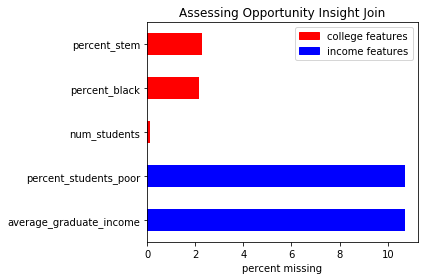

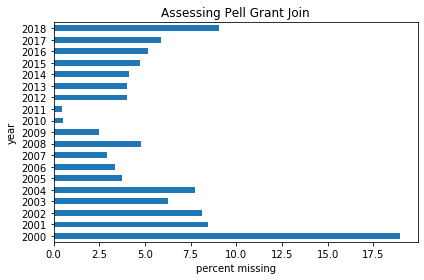

In [36]:
# Graph missing data
missing = df.isna().sum() / df.shape[0] * 100

op_insight_vars = ['k_median','par_q1','ipeds_enrollment_2013','black_share_fall_2000','pct_stem_2000']
missing_op_insight = missing[op_insight_vars]
missing_op_insight = missing_op_insight.rename({'pct_stem_2000':'percent_stem','black_share_fall_2000':'percent_black',
                                                'ipeds_enrollment_2013':'num_students','par_q1':'percent_students_poor',
                                                'k_median':'average_graduate_income'})
missing_op_insight.plot(kind='barh', color=['b','b','r','r','r'])
plt.xlabel("percent missing")
plt.title("Assessing Opportunity Insight Join")
red_patch = mpatches.Patch(color='red', label='The red data')
blue_patch = mpatches.Patch(color='blue', label='The red data')
plt.legend(handles = [red_patch, blue_patch], labels = ['college features', 'income features'])
plt.tight_layout()
plt.show()

pell_vars = ['recipients_00','recipients_01','recipients_02','recipients_03','recipients_04','recipients_05',
             'recipients_06','recipients_07','recipients_08','recipients_09','recipients_10','recipients_11',
             'recipients_12','recipients_13','recipients_14','recipients_15','recipients_16','recipients_17',
             'recipients_18']
missing_pell = missing[pell_vars]
missing_pell.rename({'recipients_00':'2000','recipients_01':'2001','recipients_02':'2002','recipients_03':'2003',
                    'recipients_04':'2004','recipients_05':'2005','recipients_06':'2006', 'recipients_07':'2007',
                    'recipients_08':'2008','recipients_09':'2009','recipients_10':'2010','recipients_11':'2011',
                    'recipients_12':'2012','recipients_13':'2013','recipients_14':'2014','recipients_15':'2015',
                    'recipients_16':'2016','recipients_17':'2017','recipients_18':'2018'}).plot(kind='barh')
# missing_pell
plt.xlabel("percent missing")
plt.ylabel('year')
plt.title("Assessing Pell Grant Join")
plt.tight_layout()
plt.show()

# Replace missing pell data with 0
#df[pell_vars] = df[pell_vars].fillna(0)

In [7]:
# Export data
df.to_csv('cleaned_dataframe.csv', index=False)

Analyze the data, draw conclusions, and effectively communicate your main observations and results.
Calculate appropriate summary statistics.
Use appropriate plotting techniques, visualizations, and other tools and techniques you have learned, to thoughtfully identify and evaluate

what the data are telling you,
how well suited the data are to answering your problem,

## Basic Visualization and Analysis Code

In [40]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
print(df.head(5))
imp.fit(df)

  super_opeid  par_median  k_median     par_q1  par_top1pc  kq5_cond_parq1  \
0      266500     30900.0   53000.0  36.477882    0.119815       44.843544   
1      727300     42800.0   57600.0  27.632242    0.559202       46.824234   
2      268800     35500.0   48500.0  32.546474    0.233515       36.021557   
3      702200     32500.0   40700.0  36.707489    0.000000       27.882967   
4      114000     36600.0   43000.0  33.116928    0.155981       29.949804   

   ktop1pc_cond_parq1  mr_kq5_pq1  mr_ktop1_pq1  trend_parq1  ...  \
0            1.766630   16.357975      0.644429    -7.998776  ...   
1            2.556827   12.938586      0.706509    -9.186549  ...   
2            1.408721   11.723747      0.458489    -9.801580  ...   
3            0.189635   10.235138      0.069610    -5.733966  ...   
4            0.083620    9.918455      0.027692   -13.313572  ...   

   recipients_14   awards_14 recipients_15   awards_15 recipients_16  \
0         1246.0   5164952.0        1236.0  

AttributeError: 'DataFrame' object has no attribute 'dtype'